<a href="https://colab.research.google.com/github/aSafarpoor/storehouse/blob/main/current_phase_until_11_55_01_6_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is mainly not mine but, I will add some parts to make it like a tutorial for myself, and then |I will change it to test my idea.

Based on: https://towardsdatascience.com/program-a-simple-graph-net-in-pytorch-e00b500a642d

Source: https://github.com/praxidike97/GraphNeuralNet/blob/72c330bb6e64dd7dd6784b6e69a821149dc5d028/main.py#L114

In [1]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 20.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 22.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 24.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 19.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

In [2]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import random
random.seed(10)

# what we need

## Graph Class

In [43]:
from itertools import filterfalse
class Graph:
    def __init__(self,nV):
        self.nV = nV
        self.V = list(range(nV))
        self.lenE = 0
        self.VnV = [[] for i in range(nV)]
        self.emV = []
        self.cc = []

    def add_edge(self,v1,v2,directed=False):
        self.VnV[v1].append(v2)
        if not directed:
            self.VnV[v2].append(v1)
        
        self.lenE += 1

    def add_self_loop(self):
        for i in range(self.nV):
            self.VnV[i].append(i)
        self.lenE += self.nV

    def create_embedding(self):
        self.emV = []
        for i in range(self.nV):
            temp = [0 for i in range(self.nV)]
            for j in self.VnV[i]:
                temp[j] = 1
            self.emV.append(temp[:])
        return self.emV
    
    def create_embedding_based_on_input(self,edges):
        self.emboi = np.zeros((self.nV,self.nV))
        for i in range(len(edges[0])):
            self.emboi[edges[0][i]][edges[1][i]] = 1
        return self.emboi

    def create_random_edges(self,index_list,num,avoid_self_loop=False,directed=False):
        for i in range(num):
            e1 = random.choice(index_list)
            e2 = random.choice(index_list)
            if avoid_self_loop:
                while(e2 == e1):
                     e2 = random.choice(index_list)
            self.add_edge(e1,e2,directed=directed)
    
    def clear_redundant_edges(self):
        self.lenE = 0
        for i in range(len(self.VnV)):
            self.VnV[i] = list(set(self.VnV[i]))
            self.lenE += len(self.VnV[i])
            self.lenE += i in self.VnV[i]
        self.lenE/=2

    def ask_nE(self,ifprint=False):
        if ifprint:
            print(int(self.lenE))
        return int(self.lenE)
    
    def edge_index(self):
        E1 = []
        E2 = []
        for i in range(self.nV):
            for j in self.VnV[i]:
                E1.append(i)
                E2.append(j)
        return [E1,E2]

    @staticmethod
    def is_commonelems(x,y):
        for value in x:
            if value in y:
                return True
        return False

    def update_cc(self,index_list):
        self.cc.append(index_list)

    def create_connected_component(self,index_list,nE):
        self.update_cc(index_list)

        n = max(nE-len(index_list),0)
        fill = [index_list[0],index_list[1]]
        self.add_edge(index_list[0],index_list[1])
        for i in range(3,len(index_list)):
            fill.append(index_list[i])
            self.add_edge(index_list[i],random.choice(fill))
        
        for i in range(n):
            self.add_edge(random.choice(fill),random.choice(fill))

g = Graph(10)
g.add_edge(1,2)
g.add_edge(0,1)
g.add_edge(3,4)
g.create_random_edges(list(range(5,10)),7)
g.add_self_loop()
g.clear_redundant_edges()
g.ask_nE(True)
print(g.edge_index())
g.create_embedding()


16
[[0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9], [0, 1, 0, 1, 2, 1, 2, 3, 4, 3, 4, 9, 5, 8, 6, 7, 6, 7, 8, 6, 9, 5]]


[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 1]]

# create dataset

In [6]:
class Data:
    def __init__(self,g):
        self.x = np.array(g.create_embedding())
        self.num_node_features = g.nV
        self.edge_index = np.array(g.edge_index())

    def create_mask(self,train_ratio=0.7):
        self.test_mask = []
        self.train_mask = []
        for i in range(len(self.edge_index[0])):
            if random.random()>train_ratio:
                self.test_mask.append(True)
                self.train_mask.append(False)

            else:
                self.train_mask.append(True)
                self.test_mask.append(False)


    def safe_create_mask(self,train_ratio=0.7):
        self.test_mask = []
        self.train_mask = []
        last_train = -1
        for i in range(len(self.edge_index[0])):
            if last_train != self.edge_index[0][i]:
                last_train = self.edge_index[0][i]
                self.train_mask.append(True)
                self.test_mask.append(False)

            elif random.random()>train_ratio:
                self.test_mask.append(True)
                self.train_mask.append(False)
            else:
                self.train_mask.append(True)
                self.test_mask.append(False)



In [7]:
data = Data(g)#g is Graph obj

In [8]:
print(data.num_node_features)
x, edge_index = data.x, data.edge_index
print(x.shape,edge_index.shape)

data.create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

data.safe_create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

10
(10, 10) (2, 26)
18
8
23
3


# test above parts

In [9]:
g = Graph(30)
g.create_random_edges(list(range(10)),7)
g.create_random_edges(list(range(10,20)),27)
g.create_random_edges(list(range(20,30)),17)

g.add_self_loop()
g.clear_redundant_edges()
g.ask_nE(True)
# g.create_embedding()

68


68

In [10]:
data = Data(g)#g is Graph obj

print(data.num_node_features)
x, edge_index = data.x, data.edge_index
print(x.shape,edge_index.shape)

data.create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

data.safe_create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

30
(30, 30) (2, 106)
68
38
83
23


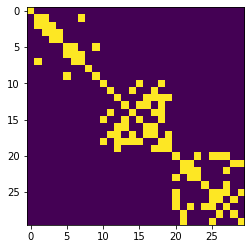

In [11]:
from matplotlib import pyplot as plt
em = g.create_embedding()
plt.imshow(em);plt.show()

In [45]:
g = Graph(50)
g.create_connected_component(list(range(10)),17)
g.create_connected_component(list(range(10,25)),47)
g.create_connected_component(list(range(25,50)),67)

g.add_self_loop()
g.clear_redundant_edges()
g.ask_nE(True)
# g.create_embedding()

149


149

In [46]:
g.cc

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 [25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49]]

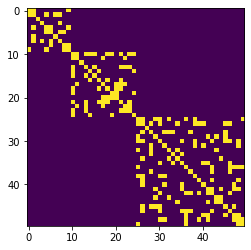

In [13]:
em = g.create_embedding()
plt.imshow(em);plt.show()

In [14]:
data = Data(g)#g is Graph obj

print(data.num_node_features)
x, edge_index = data.x, data.edge_index
print(x.shape,edge_index.shape)

data.create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

data.safe_create_mask()
print(sum(data.train_mask))
print(sum(data.test_mask))

50
(50, 50) (2, 244)
172
72
186
58


In [15]:
train = np.array([data.edge_index[0][data.train_mask],data.edge_index[1][data.train_mask]])
test = np.array([data.edge_index[0][data.test_mask],data.edge_index[1][data.test_mask]])

In [16]:
train,test

(array([[ 0,  0,  1,  1,  1,  2,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,
          6,  7,  7,  7,  8,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11,
         11, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16,
         16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20,
         20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24,
         24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27,
         28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30,
         30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 35, 35,
         35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 39,
         39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42,
         42, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 46,
         46, 46, 47, 47, 48, 48, 48, 48, 49, 49],
        [ 0,  9,  0,  4,  6,  2,  3,  7,  1,  5,  9,  8,  4,  5,  7,  1,
          6,  1,  3,  7,  8,  0,  4, 10, 11, 14, 15, 18, 19, 21, 24, 17,
 

In [17]:
etrain = g.create_embedding_based_on_input(train)
etest = g.create_embedding_based_on_input(test)

In [18]:
etrain[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

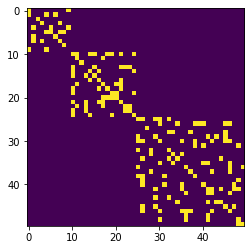

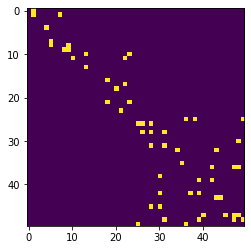

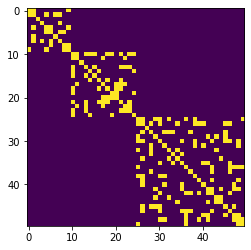

In [19]:
plt.imshow(etrain);plt.show();
plt.imshow(etest);plt.show();
plt.imshow(etest+etrain);plt.show();

now we have:

* train: edges
* test: edges
* etrain: matrix

In [20]:
print(train)
print(test)
print(etrain[:10,:10])

[[ 0  0  1  1  1  2  3  3  4  4  4  5  5  5  5  6  6  7  7  7  8  9  9 10
  10 10 10 10 10 10 10 11 11 12 13 13 13 13 13 14 14 14 14 15 15 15 16 16
  16 17 17 17 17 18 18 18 18 19 19 19 19 20 20 20 20 21 21 21 21 21 22 22
  22 22 22 23 23 23 23 24 24 24 24 25 25 25 25 25 26 26 26 26 26 26 26 27
  28 28 28 28 29 29 29 29 29 30 30 30 30 30 30 30 30 31 31 31 32 32 32 33
  33 33 34 34 34 34 35 35 35 35 35 36 36 36 36 37 37 37 37 38 38 38 38 39
  39 40 40 40 40 40 41 41 41 41 41 41 41 42 42 42 42 43 43 44 44 44 44 45
  45 45 45 46 46 46 46 46 46 46 47 47 48 48 48 48 49 49]
 [ 0  9  0  4  6  2  3  7  1  5  9  8  4  5  7  1  6  1  3  7  8  0  4 10
  11 14 15 18 19 21 24 17 11 12 10 15 21 22 23 16 24 10 14 10 13 15 16 21
  14 11 17 20 21 10 16 18 21 24 10 19 20 17 18 19 20 10 13 16 17 21 11 13
  17 22 23 10 13 22 23 24 10 19 14 32 25 26 29 30 34 38 39 40 45 46 30 27
  32 33 37 45 41 43 45 25 29 35 38 42 45 46 25 26 30 38 40 48 32 25 28 33
  35 28 32 26 44 34 33 40 41 46 30 36 46 49 25 42 28 37

# function for cf and etc.

In [21]:
def edge_convertor(edges):
    temp = []
    for i in range(len(edges[0])):
        temp.append([edges[0][i],edges[1][i]])
    return temp

In [22]:
def negative_sampler(n1,edges,nodes):
    
    n2 = random.choice(nodes)
    while [n1,n2] in edges:
           
        n2 = random.choice(nodes)
    return [n1,n2]

In [23]:
def euclidean_distance(x,y):
    return sum((x-y)**2)**0.5/(sum(abs(x))*sum(abs(y)))

In [24]:
def distance_ranker(item,l):
    s = 1
    for i in l:
        if item>i:
            s+=1 
    return s

In [25]:
raw_train,raw_test = train[:],test[:]  

#model 1: simple Cf

In [26]:
test = edge_convertor(raw_test)
train = edge_convertor(raw_train)
tt = test+train
nodes = g.V
top1 = 0
top3 = 0
avg = 0
counter_=0
for sample in tqdm(train):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain[pos[0]],etrain[pos[1]])
    dn = [euclidean_distance(etrain[neg[0]],etrain[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntrain:\n',top1,top3,avg/counter_)

top1 = 0
top3 = 0
avg = 0
counter_=0
for sample in tqdm(test):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain[pos[0]],etrain[pos[1]])
    dn = [euclidean_distance(etrain[neg[0]],etrain[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntest:\n',top1,top3,avg/counter_)

100%|██████████| 186/186 [00:00<00:00, 2993.15it/s]



train:
 106 149 2.521505376344086


100%|██████████| 58/58 [00:00<00:00, 2443.67it/s]


test:
 28 36 3.4655172413793105


next phases
* test light_GCN
* test light_GCN with leakage
* test GCN
* test GCN with leakage

# *light_GCN*

In [27]:
g.VnV

[[0, 1, 9],
 [0, 1, 4, 6, 7],
 [2],
 [3, 7],
 [1, 4, 5, 9],
 [8, 4, 5, 7],
 [1, 6],
 [1, 3, 5, 7],
 [8, 9, 5],
 [0, 8, 4, 9],
 [10, 11, 13, 14, 15, 18, 19, 21, 23, 24],
 [17, 10, 11, 22],
 [12],
 [10, 13, 15, 21, 22, 23],
 [16, 24, 10, 14],
 [10, 13, 15],
 [16, 18, 21, 14],
 [11, 17, 20, 21, 22],
 [10, 16, 18, 20, 21],
 [24, 10, 19, 20],
 [17, 18, 19, 20],
 [10, 13, 16, 17, 18, 21, 23],
 [11, 13, 17, 22, 23],
 [10, 13, 21, 22, 23],
 [24, 10, 19, 14],
 [32, 36, 38, 49, 25, 26, 29, 30],
 [34, 38, 39, 40, 45, 46, 25, 26, 28, 30],
 [27],
 [32, 33, 37, 45, 26, 28, 31],
 [41, 43, 45, 25, 29],
 [35, 38, 42, 45, 46, 48, 25, 26, 30],
 [38, 40, 48, 28, 31],
 [32, 34, 43, 25, 28],
 [33, 35, 28],
 [32, 26, 44, 34],
 [33, 35, 40, 41, 46, 30],
 [36, 42, 46, 47, 48, 49, 25],
 [42, 28, 37, 46],
 [38, 25, 26, 30, 31],
 [48, 26, 42, 39],
 [35, 40, 47, 26, 31],
 [35, 41, 42, 44, 47, 48, 29],
 [36, 37, 39, 41, 42, 46, 30],
 [32, 43, 44, 29],
 [41, 34, 43, 44],
 [45, 47, 26, 28, 29, 30],
 [35, 36, 37, 42, 

In [31]:
etrain.shape

(50, 50)

In [32]:
class LGCN:
    def __init__(self):
        pass

    @staticmethod
    def do(inmatrix,VE):
        outmatrix = np.zeros((inmatrix.shape))
        for i, v in enumerate(VE):
            siz = len(v)
            for j in v:
                outmatrix[i]+=inmatrix[j]
            outmatrix[i]/=siz
        return outmatrix

In [41]:
epoch = 3
etrain2 = np.copy(etrain)
for i in tqdm(range(epoch)):
    etrain2 = LGCN.do(etrain2,g.VnV)

100%|██████████| 3/3 [00:00<00:00, 1053.93it/s]


In [42]:
test = edge_convertor(raw_test)
train = edge_convertor(raw_train)
tt = test+train
nodes = g.V
top1 = 0
top3 = 0
avg = 0
counter_=0

for sample in tqdm(train):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntrain:\n',top1,top3,avg/counter_)

top1 = 0
top3 = 0
avg = 0
counter_=0
for sample in tqdm(test):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntest:\n',top1,top3,avg/counter_)

100%|██████████| 186/186 [00:00<00:00, 1463.25it/s]



train:
 154 181 1.3010752688172043


100%|██████████| 58/58 [00:00<00:00, 1494.29it/s]


test:
 50 57 1.1896551724137931


# light_GCN with leakage

In [53]:
class LGCNwL:
    def __init__(self):
        pass
    @staticmethod
    def new_neg_vic(inmatrix,VE,leakageratio,lambdaa,cc):
        for c1 in cc:
             if leakageratio>random.random():
                c2 = random.choice(cc)
                while c2 != c1:
                    c2 = random.choice(cc)
                    
                v1 = random.choice(c1)
                v2 = random.choice(c2)
                temp = inmatrix[v1][:]
                inmatrix[v1] -= lambdaa*inmatrix[v2]
                inmatrix[v2] -= lambdaa*temp
        
        return inmatrix

    @staticmethod
    def do(inmatrix,VE,cc,leakageratio=0.3,lambdaa=0.1):
        outmatrix = np.zeros((inmatrix.shape))
        inmatrix2 = LGCNwL.new_neg_vic(np.copy(inmatrix),VE,leakageratio,lambdaa,cc)
      
        for i, v in enumerate(VE):
            siz = len(v)
            for j in v:
                outmatrix[i]+=inmatrix2[j]
            outmatrix[i]/=siz
        return outmatrix

In [58]:
epoch = 100
etrain2 = np.copy(etrain)
for i in tqdm(range(epoch)):
    etrain2 = LGCNwL.do(etrain2,g.VnV,g.cc,leakageratio=0.1,lambdaa=0.1)

100%|██████████| 100/100 [00:00<00:00, 2226.43it/s]


In [59]:
test = edge_convertor(raw_test)
train = edge_convertor(raw_train)
tt = test+train
nodes = g.V
top1 = 0
top3 = 0
avg = 0
counter_=0

for sample in tqdm(train):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntrain:\n',top1,top3,avg/counter_)

top1 = 0
top3 = 0
avg = 0
counter_=0
for sample in tqdm(test):
    pos = sample
    negs = []
    for i in range(10):
        neg = negative_sampler(pos[0],tt,nodes)
        negs.append(neg)
    dp = euclidean_distance(etrain2[pos[0]],etrain2[pos[1]])
    dn = [euclidean_distance(etrain2[neg[0]],etrain2[neg[1]]) for neg in negs]

    r = distance_ranker(dp,dn)
    if r<2:
        top1+=1
    if r<4:
        top3+=1
    avg+=r
    counter_+=1

print('\ntest:\n',top1,top3,avg/counter_)

100%|██████████| 186/186 [00:00<00:00, 3057.23it/s]



train:
 92 155 2.096774193548387


100%|██████████| 58/58 [00:00<00:00, 2689.34it/s]


test:
 24 47 2.706896551724138


***50 node 3 component***

*top1,top3,avg:*

**simple cf**
* train:
 106 149 2.52
* test:
 28 36 3.46

**LGCN 10 layer**
* train: 
 154 181 1.30
* test: 
 50 57 1.18

**LGCN 10 layer**
* train: 
133 172 1.53
* test:
 47 57 1.31

**LGCN 100 layer**
* train:
 132 174 1.52
* test:
 43 55 1.44

**LGCNwL 3 layer leakageratio=1 lambdaa=0.1**
* train:
 88 151 2.29
* test:
 25 46 2.51

In [60]:
len(g.cc)

3